In [1]:
!pip install elasticsearch

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import os
from subprocess import Popen, PIPE, STDOUT
from elasticsearch import Elasticsearch
import elasticsearch.helpers

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import pipeline

In [3]:
#Setting up ElasticSearch

!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
!curl -X GET "localhost:9200/"
es = Elasticsearch()
es.ping()

{
  "name" : "4366206183fe",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "J6CD9NBiRaSfUy4zT-FDbA",
  "version" : {
    "number" : "7.0.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "b7e28a7",
    "build_date" : "2019-04-05T22:55:32.697037Z",
    "build_snapshot" : false,
    "lucene_version" : "8.0.0",
    "minimum_wire_compatibility_version" : "6.7.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


True

In [4]:
def read_data(source_file):
    
    data = pd.read_csv(source_file,index_col=0)
    data = data.fillna(0)
    
    return data

In [5]:
def insert_data(data, es, this_index):

    for row_id, row in data.iterrows():

        doc = row.to_dict()
        es.index(index= this_index, id= row_id, body= doc)
    

In [2]:
def scan_full_database(es, this_index):
    
    documents = elasticsearch.helpers.scan(es,
        index= this_index,
        preserve_order=True,
        query={"query": {"match_all": {}}},
    )
    
    tweets = []
    
    for document in documents:
        cleaned_tweet = clean_text(document["_source"]["tweet"])
        tweets.append(cleaned_tweet)
    
    return tweets


In [5]:
def clean_text(text):
    
    text = re.sub('https?://\S+|www\.\S+', '', text) #Remove URL
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Remove punctuation
    
    return text

In [4]:
def NER_model(text, ner):
    
    #ner = pipeline('ner', grouped_entities=True)
    output = ner(text)
    
    entities = []
    
    for instance in output:
        entity_tuple = (instance['entity_group'], instance['word'])
        entities.append(entity_tuple)
    
    
    return entities
    #doc = nlp(text)
    #return doc.ents

In [3]:

def get_entities (tweets, ner):
    
    entity_dictionary = {}
    
    for tweet in tweets:
        
        entities = NER_model(tweet, ner)
        
        for entity in entities:
            
            if (entity[0] not in entity_dictionary):
                entity_dictionary[entity[0]] = {}
                
            if (entity[1] not in entity_dictionary[entity[0]]):
                entity_dictionary[entity[0]][entity[1]] = 0
                
            entity_dictionary[entity[0]][entity[1]] += 1
            
    return entity_dictionary
        

In [20]:
def show_wordcloud(dictionary):
    wordcloud = WordCloud(max_words=50,normalize_plurals=False,background_color='white').generate_from_frequencies(dictionary)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [12]:
data = read_data("/kaggle/input/all-trumps-twitter-insults-20152021/trump_insult_tweets_2014_to_2021.csv")
insert_data(data, es, "trump_tweets")


In [ ]:
tweets = scan_full_database(es, "trump_tweets")

In [ ]:
ner = pipeline('ner', grouped_entities=True)
entity_dictionary = get_entities(tweets[:1000], ner)

PER


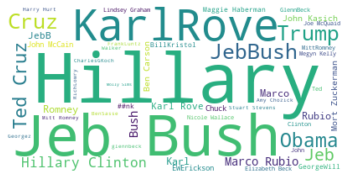

ORG


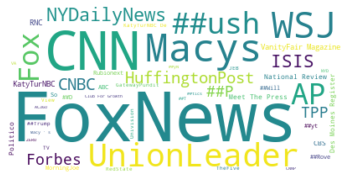

LOC


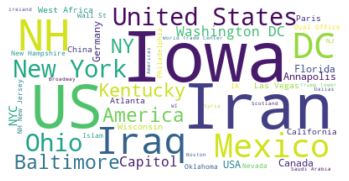

MISC


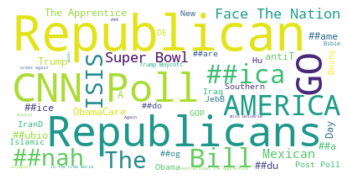

In [26]:
for key in entity_dictionary:
    
    print(key)
    show_wordcloud(entity_dictionary[key])
    
    